# STAT202A HW5 --- Convolutional Networks
So far we have worked with fully-connected networks, using them to explore different optimization strategies and network architectures. Fully-connected networks are a good testbed for experimentation because they are very computationally efficient, but in practice all state-of-the-art results use convolutional networks instead.

In this homework, your are required to implement convolution layer, forward and backward. All other part of the code are given. You will then use these layers to train a convolutional network on the CIFAR-10 dataset.

Please following these steps,

- STEP 1: Implement two function in second block, CNN forward and backward.
- STEP 2: Read the code I provided, especially code in this pythonbook, the definition of CNN network in second block class. Add comments to codes in second blocks. (You can also read code provided in zip, but you do not need to make comment)
- STEP 3: Run each block one by one see every thing works well.
- STEP 4: Try to turn the learning rate and other setting to make final cifar learning well. Notice the cifar training use fast version CNN so this is not affected by your implementation. i.e. even you you fail to implement CNN layer, you can still it play it.
- STEP 5: Doing more extra play at the end of this pythonbook. e.g. : Try to virtualize more filter / try to plot an accuracy according to different setting / calculate the accuracy by each class ... It is extra and optional.
- STEP 6: Press Ctrl + P (or Commend + P) to print this page to pdf. Then download this ipynb files. 
- STEP 7: Submit the pdf and ipynb files only to ccle. (Two files, pdf and ipynb, no other filetype accepted)

In order to useit in  google Colab, **remember to change Runtime -> change runtime type -> python version from python 3 to python 2**. Then run the first block, select the zip files I provided to upload and this block of code will automaticlly unzip it. Then, it will download cifar files and makefiles. 

If any problem caused later and crack the runtime. Remember to reset the runtime by Runtime -> Reset all runtimes and rerun the first block.

In [47]:
from google.colab import files
uploaded = files.upload()
!unzip HW5_code
!pip install Cython==0.21
!python HW5_code/setup.py build_ext --inplace
!mv im2col_cython.c HW5_code/im2col_cython.c
!mv im2col_cython.so HW5_code/im2col_cython.so
!mv im2col_cython.pyx HW5_code/im2col_cython.pyx
!wget http://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar -xzvf cifar-10-python.tar.gz
!rm cifar-10-python.tar.gz 

Saving HW5_code (2).zip to HW5_code (2).zip
Archive:  HW5_code.zip
replace HW5_code/data_utils.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: HW5_code/data_utils.py  
replace HW5_code/fast_layers.py? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: HW5_code/fast_layers.py  
  inflating: HW5_code/gradient_check.py  
  inflating: HW5_code/im2col.py      
  inflating: HW5_code/layers.py      
  inflating: HW5_code/layer_utils.py  
  inflating: HW5_code/optim.py       
  inflating: HW5_code/setup.py       
  inflating: HW5_code/solver.py      
  inflating: HW5_code/vis_utils.py   
 extracting: HW5_code/__init__.py    
  inflating: im2col_cython.pyx       
Compiling im2col_cython.pyx because it changed.
Cythonizing im2col_cython.pyx
running build_ext
building 'im2col_cython' extension
x86_64-linux-gnu-gcc -pthread -DNDEBUG -g -fwrapv -O2 -Wall -Wstrict-prototypes -fno-strict-aliasing -Wdate-time -D_FORTIFY_SOURCE=2 -g -fdebug-prefix-map=/build/python2.7-nbjU53/python2.7-2.7.15

In [49]:
# As usual, a bit of setup
from __future__ import print_function
import numpy as np
import matplotlib.pyplot as plt
from HW5_code.data_utils import get_CIFAR10_data
from HW5_code.gradient_check import eval_numerical_gradient_array, eval_numerical_gradient
from HW5_code.layers import *
from HW5_code.fast_layers import *
from HW5_code.solver import Solver
from HW5_code.layer_utils import *

%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

def rel_error(x, y):
  """ returns relative error """
  return np.max(np.abs(x - y) / (np.maximum(1e-8, np.abs(x) + np.abs(y))))

class ThreeLayerConvNet(object):
    """
    A three-layer convolutional network with the following architecture:
    conv - relu - 2x2 max pool - fc - relu - fc - softmax
    The network operates on minibatches of data that have shape (N, C, H, W)
    consisting of N images, each with height H and width W and with C input
    channels.
    """

    def __init__(self, input_dim=(3, 32, 32), num_filters=32, filter_size=7,
                 hidden_dim=100, num_classes=10, weight_scale=1e-3, reg=0.0,
                 dtype=np.float32):
        """
        Initialize a new network.
        Inputs:
        - input_dim: Tuple (C, H, W) giving size of input data
        - num_filters: Number of filters to use in the convolutional layer
        - filter_size: Size of filters to use in the convolutional layer
        - hidden_dim: Number of units to use in the fully-connected hidden layer
        - num_classes: Number of scores to produce from the final fc layer.
        - weight_scale: Scalar giving standard deviation for random initialization
          of weights.
        - reg: Scalar giving L2 regularization strength
        - dtype: numpy datatype to use for computation.
        """
        self.params = {}
        self.reg = reg
        self.dtype = dtype
        
        C, H, W = input_dim
        self.params['W1'] = np.random.normal(0, weight_scale, [num_filters, 3, filter_size, filter_size])
        self.params['b1'] = np.zeros([num_filters])
        self.params['W2'] = np.random.normal(0, weight_scale, [np.int(H/2)*np.int(H/2)*num_filters, hidden_dim])
        self.params['b2'] = np.zeros([hidden_dim])
        self.params['W3'] = np.random.normal(0, weight_scale, [hidden_dim, num_classes])
        self.params['b3'] = np.zeros([num_classes])

        for k, v in self.params.items():
            self.params[k] = v.astype(dtype)


    def loss(self, X, y=None):
        """
        Evaluate loss and gradient for the three-layer convolutional network.
        Input / output: Same API as TwoLayerNet in fc_net.py.
        """
        W1, b1 = self.params['W1'], self.params['b1']
        W2, b2 = self.params['W2'], self.params['b2']
        W3, b3 = self.params['W3'], self.params['b3']

        # pass conv_param to the forward pass for the convolutional layer
        filter_size = W1.shape[2]
        
        # stride: step size that filter scans over image
        # pad: add additional zeros out of the image to match the input and output size
        conv_param = {'stride': 1, 'pad': (filter_size - 1) // 2}

        # pass pool_param to the forward pass for the max-pooling layer
        pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

        scores = None
        
        # forward pass
        layer1_out, combined_cache = conv_relu_pool_forward(X, W1, b1,  conv_param, pool_param)
        fc1_out, fc1_cache = fc_forward(layer1_out, W2, b2)
        relu2_out, relu2_cache = relu_forward(fc1_out)
        fc2_out, fc2_cache = fc_forward(relu2_out, W3, b3)

        scores = np.copy(fc2_out)
        if y is None:
            return scores

        loss, grads = 0, {}
        
        loss, dsoft = softmax_loss(scores, y)
        loss += self.reg*0.5*(np.sum(np.square(W1)) + np.sum(np.square(W2)) + np.sum(np.square(W3)))
        
        
        # backward pass
        dx3, dw3, db3 = fc_backward(dsoft, fc2_cache)
        drelu2 = relu_backward(dx3, relu2_cache)
        dx2, dw2, db2 = fc_backward(drelu2, fc1_cache)
        dx1, dw1, db1 = conv_relu_pool_backward(dx2, combined_cache)

        grads['W3'], grads['b3'] = dw3 + self.reg*W3, db3
        grads['W2'], grads['b2'] = dw2 + self.reg*W2, db2
        grads['W1'], grads['b1'] = dw1 + self.reg*W1, db1

        return loss, grads


def conv_forward_naive(x, w, b, conv_param):
    """
    A naive implementation of the forward pass for a convolutional layer.

    The input consists of N data points, each with C channels, height H and
    width W. We convolve each input with F different filters, where each filter
    spans all C channels and has height HH and width HH.

    Input:
    - x: Input data of shape (N, C, H, W)
    - w: Filter weights of shape (F, C, HH, WW)
    - b: Biases, of shape (F,)
    - conv_param: A dictionary with the following keys:
      - 'stride': The number of pixels between adjacent receptive fields in the
        horizontal and vertical directions.
      - 'pad': The number of pixels that will be used to zero-pad the input.

    Returns a tuple of:
    - out: Output data, of shape (N, F, H', W') where H' and W' are given by
      H' = 1 + (H + 2 * pad - HH) / stride
      W' = 1 + (W + 2 * pad - WW) / stride
    - cache: (x, w, b, conv_param)
    """
    out = None

    pad = conv_param.get('pad')
    stride = conv_param.get('stride')
    N, C, H, W = x.shape
    F, C, HH, WW = w.shape

    # redefine the output shape based on stride number
    out_H = np.int(((H + 2 * pad - HH) / stride) + 1)# Define it
    out_W = np.int(((W + 2 * pad - WW) / stride) + 1)# Define it
    out = np.zeros([N, F, out_H, out_W])
    
    # add zeros around the original image to match input and output size
    padded_x = (np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant'))

    for n in range(N): 
        for f in range(F): 
            for j in range(out_H):
                for i in range(out_W): 
                    out[n, f, j, i] = np.sum(w[f, ...] * padded_x[n, :, j*stride:j*stride+HH, i*stride:i*stride+WW]) + b[f]
                    
                    

                                        
    ###########################################################################
    # TODO: Implement the convolutional forward pass.                         #
    # Hint: you can use the function np.pad for padding.                      #
    ###########################################################################
                        
    cache = (x, w, b, conv_param)
    return out, cache


def conv_backward_naive(dout, cache):
    """
    A naive implementation of the backward pass for a convolutional layer.

    Inputs:
    - dout: Upstream derivatives.
    - cache: A tuple of (x, w, b, conv_param) as in conv_forward_naive

    Returns a tuple of:
    - dx: Gradient with respect to x
    - dw: Gradient with respect to w
    - db: Gradient with respect to b
    """
    dx, dw, db = None, None, None
    ###########################################################################
    # TODO: Implement the convolutional backward pass.                        #
    ###########################################################################
    
    x, w, b, conv_param = cache
    stride = conv_param.get('stride')
    pad = conv_param.get('pad')
    padded_x = (np.pad(x, ((0, 0), (0, 0), (pad, pad), (pad, pad)), 'constant'))

    N, C, H, W = x.shape
    F, C, HH, WW = w.shape
    N, F, H_out, W_out = dout.shape

    dx_temp = np.zeros_like(padded_x)
    dw = np.zeros_like(w)
    db = np.zeros_like(b)


    
    # Calculate dB.
    for f in range(F): 
        db[f] += np.sum(dout[:, f, :, :])
    # Calculate dw.
    for n in range(N): # n th image
        for f in range(F): # f th filter 
            for j in range(H_out): # the jth column position of fth filter
                for i in range(W_out): # the ith row position of fth filter
                    dw[f, ...] += dout[n, f, j, i] * \
                    padded_x[n,:,j*stride:j*stride+HH,i*stride:i*stride+WW]
    # Calculate dx.
    for n in range(N): 
        for f in range(F):
            for j in range(H_out):
                for i in range(W_out):
                    dx_temp[n, :, j*stride:j*stride+HH,i*stride:i*stride+WW] \
                    += dout[n, f, j,i] * w[f, ...]
                    
                    
    dx = dx_temp[:, :, pad:H+pad, pad:W+pad]
    return dx, dw, db



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [50]:
# Load the (preprocessed) CIFAR10 data.

data = get_CIFAR10_data()
for k, v in data.items():
  print('%s: ' % k, v.shape)

X_val:  (1000, 3, 32, 32)
X_train:  (49000, 3, 32, 32)
X_test:  (1000, 3, 32, 32)
y_val:  (1000,)
y_train:  (49000,)
y_test:  (1000,)


# Convolution: Naive forward pass
The core of a convolutional network is the convolution operation. In the file `stats232a/layers.py`, implement the forward pass for the convolution layer in the function `conv_forward_naive`. 

You don't have to worry too much about efficiency at this point; just write the code in whatever way you find most clear.

You can test your implementation by running the following:

In [51]:
x_shape = (2, 3, 4, 4)
w_shape = (3, 3, 4, 4)
x = np.linspace(-0.1, 0.5, num=np.prod(x_shape)).reshape(x_shape)
w = np.linspace(-0.2, 0.3, num=np.prod(w_shape)).reshape(w_shape)
b = np.linspace(-0.1, 0.2, num=3)

conv_param = {'stride': 2, 'pad': 1}
out, _ = conv_forward_naive(x, w, b, conv_param)
correct_out = np.array([[[[-0.08759809, -0.10987781],
                           [-0.18387192, -0.2109216 ]],
                          [[ 0.21027089,  0.21661097],
                           [ 0.22847626,  0.23004637]],
                          [[ 0.50813986,  0.54309974],
                           [ 0.64082444,  0.67101435]]],
                         [[[-0.98053589, -1.03143541],
                           [-1.19128892, -1.24695841]],
                          [[ 0.69108355,  0.66880383],
                           [ 0.59480972,  0.56776003]],
                          [[ 2.36270298,  2.36904306],
                           [ 2.38090835,  2.38247847]]]])

# Compare your output to ours; difference should be around 2e-8
print('Testing conv_forward_naive')
print('difference: ', rel_error(out, correct_out))

Testing conv_forward_naive
difference:  2.2121476417505994e-08


# Convolution: Naive backward pass
Implement the backward pass for the convolution operation in the function `conv_backward_naive` in the file `stats232a/layers.py`. Again, you don't need to worry too much about computational efficiency.

When you are done, run the following to check your backward pass with a numeric gradient check.

In [52]:
np.random.seed(231)
x = np.random.randn(4, 3, 5, 5)
w = np.random.randn(2, 3, 3, 3)
b = np.random.randn(2,)
dout = np.random.randn(4, 2, 5, 5)
conv_param = {'stride': 1, 'pad': 1}

dx_num = eval_numerical_gradient_array(lambda x: conv_forward_naive(x, w, b, conv_param)[0], x, dout)
dw_num = eval_numerical_gradient_array(lambda w: conv_forward_naive(x, w, b, conv_param)[0], w, dout)
db_num = eval_numerical_gradient_array(lambda b: conv_forward_naive(x, w, b, conv_param)[0], b, dout)

out, cache = conv_forward_naive(x, w, b, conv_param)
dx, dw, db = conv_backward_naive(dout, cache)

# Your errors should be around 1e-8'
print('Testing conv_backward_naive function')
print('dx error: ', rel_error(dx, dx_num))
print('dw error: ', rel_error(dw, dw_num))
print('db error: ', rel_error(db, db_num))

Testing conv_backward_naive function
dx error:  1.159803161159293e-08
dw error:  2.2471264748452487e-10
db error:  3.3726153958780465e-11


# Fast layers
Making convolution and pooling layers fast can be challenging. To spare you the pain, we've provided fast implementations of the forward and backward passes for convolution and pooling layers in the file `stats232a/fast_layers.py`.

The fast convolution implementation depends on a Cython extension; to compile it you need to run the following from the `stats232a` directory:

```bash
python setup.py build_ext --inplace
```

The API for the fast versions of the convolution and pooling layers is exactly the same as the naive versions that you implemented above: the forward pass receives data, weights, and parameters and produces outputs and a cache object; the backward pass recieves upstream derivatives and the cache object and produces gradients with respect to the data and weights.

**NOTE:** The fast implementation for pooling will only perform optimally if the pooling regions are non-overlapping and tile the input. If these conditions are not met then the fast pooling implementation will not be much faster than the naive implementation.

You can compare the performance of the naive and fast versions of these layers by running the following:

In [53]:
from HW5_code.fast_layers import conv_forward_fast, conv_backward_fast
from time import time
np.random.seed(231)
x = np.random.randn(100, 3, 31, 31)
w = np.random.randn(25, 3, 3, 3)
b = np.random.randn(25,)
dout = np.random.randn(100, 25, 16, 16)
conv_param = {'stride': 2, 'pad': 1}

t0 = time()
out_naive, cache_naive = conv_forward_naive(x, w, b, conv_param)
t1 = time()
out_fast, cache_fast = conv_forward_fast(x, w, b, conv_param)
t2 = time()

print('Testing conv_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('Difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive, dw_naive, db_naive = conv_backward_naive(dout, cache_naive)
t1 = time()
dx_fast, dw_fast, db_fast = conv_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting conv_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('Fast: %fs' % (t2 - t1))
print('Speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))
print('dw difference: ', rel_error(dw_naive, dw_fast))
print('db difference: ', rel_error(db_naive, db_fast))

Testing conv_forward_fast:
Naive: 5.567968s
Fast: 0.017584s
Speedup: 316.648136x
Difference:  4.926407851494105e-11

Testing conv_backward_fast:
Naive: 9.390247s
Fast: 0.014021s
Speedup: 669.731176x
dx difference:  1.949764775345631e-11
dw difference:  3.681156828004736e-13
db difference:  3.1393858025571252e-15


In [54]:
from HW5_code.fast_layers import max_pool_forward_fast, max_pool_backward_fast
np.random.seed(231)
x = np.random.randn(100, 3, 32, 32)
dout = np.random.randn(100, 3, 16, 16)
pool_param = {'pool_height': 2, 'pool_width': 2, 'stride': 2}

t0 = time()
out_naive, cache_naive = max_pool_forward_naive(x, pool_param)
t1 = time()
out_fast, cache_fast = max_pool_forward_fast(x, pool_param)
t2 = time()

print('Testing pool_forward_fast:')
print('Naive: %fs' % (t1 - t0))
print('fast: %fs' % (t2 - t1))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('difference: ', rel_error(out_naive, out_fast))

t0 = time()
dx_naive = max_pool_backward_naive(dout, cache_naive)
t1 = time()
dx_fast = max_pool_backward_fast(dout, cache_fast)
t2 = time()

print('\nTesting pool_backward_fast:')
print('Naive: %fs' % (t1 - t0))
print('speedup: %fx' % ((t1 - t0) / (t2 - t1)))
print('dx difference: ', rel_error(dx_naive, dx_fast))

Testing pool_forward_fast:
Naive: 0.406031s
fast: 0.002661s
speedup: 152.586417x
difference:  0.0

Testing pool_backward_fast:
Naive: 0.512846s
speedup: 39.205924x
dx difference:  0.0


# Three-layer ConvNet
Now that you have implemented all the necessary layers, we can put them together into a simple convolutional network.

Open the file `stats232a/classifiers/cnn.py` and complete the implementation of the `ThreeLayerConvNet` class. Run the following cells to help you debug:

## Sanity check loss
After you build a new network, one of the first things you should do is sanity check the loss. When we use the softmax loss, we expect the loss for random weights (and no regularization) to be about `log(C)` for `C` classes. When we add regularization this should go up.

In [55]:
model = ThreeLayerConvNet()

N = 50
X = np.random.randn(N, 3, 32, 32)
y = np.random.randint(10, size=N)

loss, grads = model.loss(X, y)
print('Initial loss (no regularization): ', loss)

model.reg = 0.5
loss, grads = model.loss(X, y)
print('Initial loss (with regularization): ', loss)

Initial loss (no regularization):  2.3025858848360223
Initial loss (with regularization):  2.508810654189889


## Gradient check
After the loss looks reasonable, use numeric gradient checking to make sure that your backward pass is correct. When you use numeric gradient checking you should use a small amount of artifical data and a small number of neurons at each layer. Note: correct implementations may still have relative errors up to 1e-2.

In [56]:
num_inputs = 2
input_dim = (3, 16, 16)
reg = 0.0
num_classes = 10
np.random.seed(231)
X = np.random.randn(num_inputs, *input_dim)
y = np.random.randint(num_classes, size=num_inputs)

model = ThreeLayerConvNet(num_filters=3, filter_size=3,
                          input_dim=input_dim, hidden_dim=7,
                          dtype=np.float64)
loss, grads = model.loss(X, y)
for param_name in sorted(grads):
    f = lambda _: model.loss(X, y)[0]
    param_grad_num = eval_numerical_gradient(f, model.params[param_name], verbose=False, h=1e-6)
    e = rel_error(param_grad_num, grads[param_name])
    print('%s max relative error: %e' % (param_name, rel_error(param_grad_num, grads[param_name])))

W1 max relative error: 1.380104e-04
W2 max relative error: 1.822723e-02
W3 max relative error: 3.064049e-04
b1 max relative error: 3.477652e-05
b2 max relative error: 2.516375e-03
b3 max relative error: 7.945660e-10


## Overfit small data
A nice trick is to train your model with just a few training samples. You should be able to overfit small datasets, which will result in very high training accuracy and comparatively low validation accuracy.

In [57]:
np.random.seed(6666666)

num_train = 100
small_data = {
  'X_train': data['X_train'][:num_train],
  'y_train': data['y_train'][:num_train],
  'X_val': data['X_val'],
  'y_val': data['y_val'],
}

model = ThreeLayerConvNet(weight_scale=1e-2)

solver = Solver(model, small_data,
                num_epochs=15, batch_size=50,
                update_rule='adam',
                optim_config={
                  'learning_rate': 1e-3,
                },
                verbose=True, print_every=1)
solver.train()

(Epoch 0 / 15, iteration 1 / 30) train acc: 0.170000; val_acc: 0.119000
(Epoch 1 / 15, iteration 2 / 30) train acc: 0.180000; val_acc: 0.119000
(Epoch 1 / 15, iteration 3 / 30) train acc: 0.250000; val_acc: 0.134000
(Epoch 2 / 15, iteration 4 / 30) train acc: 0.260000; val_acc: 0.121000
(Epoch 2 / 15, iteration 5 / 30) train acc: 0.210000; val_acc: 0.109000
(Epoch 3 / 15, iteration 6 / 30) train acc: 0.400000; val_acc: 0.128000
(Epoch 3 / 15, iteration 7 / 30) train acc: 0.400000; val_acc: 0.119000
(Epoch 4 / 15, iteration 8 / 30) train acc: 0.400000; val_acc: 0.150000
(Epoch 4 / 15, iteration 9 / 30) train acc: 0.360000; val_acc: 0.164000
(Epoch 5 / 15, iteration 10 / 30) train acc: 0.380000; val_acc: 0.150000
(Epoch 5 / 15, iteration 11 / 30) train acc: 0.380000; val_acc: 0.112000
(Epoch 6 / 15, iteration 12 / 30) train acc: 0.420000; val_acc: 0.127000
(Epoch 6 / 15, iteration 13 / 30) train acc: 0.560000; val_acc: 0.164000
(Epoch 7 / 15, iteration 14 / 30) train acc: 0.580000; val_a

Plotting the loss, training accuracy, and validation accuracy should show clear overfitting:

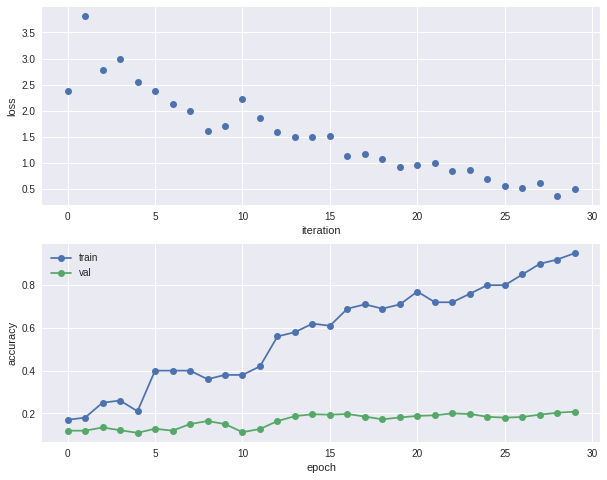

In [58]:
plt.subplot(2, 1, 1)
plt.plot(solver.loss_history, 'o')
plt.xlabel('iteration')
plt.ylabel('loss')

plt.subplot(2, 1, 2)
plt.plot(solver.train_acc_history, '-o')
plt.plot(solver.val_acc_history, '-o')
plt.legend(['train', 'val'], loc='upper left')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.show()

## Train the net
By training the three-layer convolutional network for one epoch, you should achieve greater than 40% accuracy on the training set:

In [60]:
model = ThreeLayerConvNet(reg=0.001)

# Try to change update_rule : 'sgd' / 'sgd_momentum' / 'rmsprop' / 'adam'
# Then try learning rate and reg.

solver = Solver(model, data,
                num_epochs=1, batch_size=200,
                update_rule='adam',
                optim_config={
                  'learning_rate': 0.001,
                },
                verbose=True, print_every=20)
solver.train()

(Epoch 0 / 1, iteration 1 / 245) train acc: 0.096000; val_acc: 0.098000
(Epoch 0 / 1, iteration 21 / 245) train acc: 0.292000; val_acc: 0.327000
(Epoch 0 / 1, iteration 41 / 245) train acc: 0.411000; val_acc: 0.395000
(Epoch 0 / 1, iteration 61 / 245) train acc: 0.406000; val_acc: 0.423000
(Epoch 0 / 1, iteration 81 / 245) train acc: 0.435000; val_acc: 0.451000
(Epoch 0 / 1, iteration 101 / 245) train acc: 0.461000; val_acc: 0.453000
(Epoch 0 / 1, iteration 121 / 245) train acc: 0.457000; val_acc: 0.484000
(Epoch 0 / 1, iteration 141 / 245) train acc: 0.477000; val_acc: 0.490000
(Epoch 0 / 1, iteration 161 / 245) train acc: 0.508000; val_acc: 0.493000
(Epoch 0 / 1, iteration 181 / 245) train acc: 0.477000; val_acc: 0.488000
(Epoch 0 / 1, iteration 201 / 245) train acc: 0.495000; val_acc: 0.511000
(Epoch 0 / 1, iteration 221 / 245) train acc: 0.501000; val_acc: 0.512000
(Epoch 0 / 1, iteration 241 / 245) train acc: 0.513000; val_acc: 0.523000
(Epoch 1 / 1, iteration 245 / 245) train acc

## Visualize Filters
You can visualize the first-layer convolutional filters from the trained network by running the following:

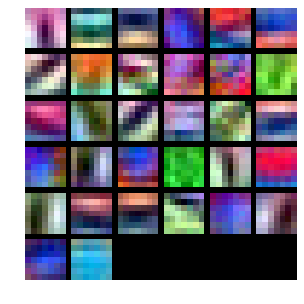

In [65]:
from HW5_code.vis_utils import visualize_grid

grid = visualize_grid(model.params['W1'].transpose(0, 2, 3, 1))
plt.imshow(grid.astype('uint8'))
plt.axis('off')
plt.gcf().set_size_inches(5, 5)
plt.show()

##Extra Credit

Try to more interesting observation as you wish! 

In [44]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

Copyright: This tamplate is original from Stanford cs231n opensource online course. Modification is made by Ruiqi Gao and Yifei Xu. No distribution is permitted.